In [17]:
# ✅ [1차 학습 Step 1] 작업 디렉토리 확인
# 맥북용 설정
import os
print("📁 현재 작업 디렉토리:", os.getcwd())

📁 현재 작업 디렉토리: /Users/freemanyoo/develop/crawler/multi_crawler


In [18]:
# ✅ [1차 학습 Step 2] 데이터 로딩 및 전처리 (⚖️ 클래스 불균형 해결!)
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from collections import Counter

# 데이터 폴더 경로 설정 (맥북 로컬 경로)
data_dir = "/Users/freemanyoo/develop/crawler/multi_crawler/class"

# 훈련용 데이터 증강 (Data Augmentation) - 과적합 방지!
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
    transforms.RandomRotation(15),  # ±15도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 검증용 데이터 변환 (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 전체 데이터셋 로드 (일단 검증용 transform으로)
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

# 데이터셋을 훈련용(80%)과 검증용(20%)으로 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 훈련 데이터셋에 증강 적용
train_dataset.dataset.transform = train_transform

# ⚖️ WeightedRandomSampler 생성 (클래스 불균형 해결!)
# 1. 훈련 데이터의 클래스별 개수 계산
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(train_targets)
print("\n⚖️ 클래스 불균형 해결 시작...")
print("📊 훈련 데이터 클래스별 개수:")
for class_idx, count in sorted(class_counts.items()):
    print(f"  - {full_dataset.classes[class_idx]}: {count}장")

# 2. 각 클래스의 가중치 계산 (적은 클래스일수록 높은 가중치)
class_weights = {class_idx: 1.0 / count for class_idx, count in class_counts.items()}

# 3. 각 샘플에 대한 가중치 할당
sample_weights = [class_weights[target] for target in train_targets]

# 4. WeightedRandomSampler 생성
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # 중복 샘플링 허용 (적은 클래스를 더 자주 샘플링)
)

# 데이터 로더 생성 (sampler 사용 시 shuffle=False!)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 목록 확인
class_names = full_dataset.classes
print(f"\n✅ 클래스 목록: {class_names}")
print(f"📊 총 이미지 개수: {len(full_dataset)}장")
print(f"  🔵 훈련 데이터: {train_size}장 (80%) + 데이터 증강 적용")
print(f"  🟢 검증 데이터: {val_size}장 (20%)")
print(f"\n⚖️ WeightedRandomSampler 적용 완료!")
print(f"  → 모든 클래스를 동등하게 학습합니다! 🎯")



⚖️ 클래스 불균형 해결 시작...
📊 훈련 데이터 클래스별 개수:
  - 감바스: 404장
  - 숯불치킨: 393장
  - 양념치킨: 332장
  - 파스타: 703장
  - 후라이드치킨: 572장

✅ 클래스 목록: ['감바스', '숯불치킨', '양념치킨', '파스타', '후라이드치킨']
📊 총 이미지 개수: 3006장
  🔵 훈련 데이터: 2404장 (80%) + 데이터 증강 적용
  🟢 검증 데이터: 602장 (20%)

⚖️ WeightedRandomSampler 적용 완료!
  → 모든 클래스를 동등하게 학습합니다! 🎯


In [19]:
# 📌 [선택사항] 클래스별 이미지 개수 확인
import os

# 데이터 폴더 경로 설정 (맥북 로컬 경로)
data_dir = "/Users/freemanyoo/develop/crawler/multi_crawler/class"

# 폴더 안에 있는 클래스 확인
print("🔍 데이터셋 폴더 내 클래스 확인:")
if os.path.exists(data_dir):
    print(os.listdir(data_dir))
    # 각 클래스별 이미지 개수 확인
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            img_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  📁 {class_name}: {img_count}장")
else:
    print(f"❌ 경로를 찾을 수 없습니다: {data_dir}")


🔍 데이터셋 폴더 내 클래스 확인:
['파스타', '후라이드치킨', '양념치킨', '감바스', '숯불치킨']
  📁 파스타: 880장
  📁 후라이드치킨: 710장
  📁 양념치킨: 421장
  📁 감바스: 502장
  📁 숯불치킨: 493장


In [20]:
# ✅ [1차 학습 Step 3] EfficientNet-B0 모델 생성
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# EfficientNet 모델 사용 (전이 학습 - Transfer Learning)
# 클래스 개수 설정
num_classes = len(class_names)

# EfficientNet-B0 사전 학습된 모델 불러오기
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# 마지막 Classifier Layer를 우리의 클래스 수에 맞게 변경
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# 최적화 함수 및 손실 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.001)

print(f"✅ EfficientNet-B0 모델 생성 완료 (클래스 수: {num_classes})")
print(f"📊 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"🎯 전이 학습 (Transfer Learning) 적용:")
print(f"   - ImageNet 사전 학습 가중치 사용")
print(f"   - 224x224 입력 크기")
print(f"   - 마지막 Classifier만 {num_classes}개 클래스로 변경")
print(f"   - Learning Rate: 0.0002")
print(f"   - Weight Decay: 0.001")
print(f"💪 EfficientNet은 ResNet보다 효율적이고 정확합니다!")


✅ EfficientNet-B0 모델 생성 완료 (클래스 수: 5)
📊 모델 파라미터 수: 4,013,953
🎯 전이 학습 (Transfer Learning) 적용:
   - ImageNet 사전 학습 가중치 사용
   - 224x224 입력 크기
   - 마지막 Classifier만 5개 클래스로 변경
   - Learning Rate: 0.0002
   - Weight Decay: 0.001
💪 EfficientNet은 ResNet보다 효율적이고 정확합니다!


In [ ]:
# ⛔⛔⛔ [1차 학습 시 실행하지 않음!] ⛔⛔⛔
# 🔥 [2차 Fine-tuning 용] 더 강한 데이터 증강
print("🔄 추가 학습을 위해 데이터 증강을 강화합니다...")

train_transform_enhanced = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # 15 → 20도로 증가
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # 더 강화
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 약간의 이동
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 훈련 데이터셋에 강화된 증강 적용
train_dataset.dataset.transform = train_transform_enhanced

# 데이터 로더 재생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("✅ 데이터 증강 강화 완료!")
print("   - 이미지 크기: 224x224 (ResNet 표준)")
print("   - 회전: ±20도")
print("   - 색상 변화: 30%")
print("   - 위치 이동: 10%")


In [ ]:
# ⛔⛔⛔ [1차 학습 시 실행하지 않음!] ⛔⛔⛔
# 🎯 [2차 Fine-tuning 용] 30 에폭 추가 학습
print("🚀 추가 학습을 시작합니다...\n")

# Learning Rate를 낮춰서 미세 조정
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.001)
# 기존 0.001 → 0.0003 (1/3로 감소)

num_epochs = 30  # 30 에폭 추가 학습

# 맥북 GPU (Apple Silicon MPS) 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Apple Silicon GPU (MPS) 사용!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("🔥 CUDA GPU 사용!")
else:
    device = torch.device("cpu")
    print("💻 CPU 사용")

model.to(device)

# 현재까지의 최고 기록 유지 (Fine-tuning 시작)
best_val_accuracy = 91.89  # 이전 최고 기록 유지
print(f"📊 Fine-tuning 시작 (이전 최고: 91.89%)")
print(f"🎯 목표: 92~93% 달성\n")

for epoch in range(num_epochs):
    # ========== 훈련 단계 ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # ========== 검증 단계 ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  🔵 훈련 - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  🟢 검증 - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    # 최고 검증 정확도 갱신 시
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f"  ✨ 새로운 최고 검증 정확도! {best_val_accuracy:.2f}%")
        # 최고 모델 즉시 저장 (Fine-tuning 전용 이름)
        torch.save(model.state_dict(), 
                   "/Users/freemanyoo/develop/crawler/multi_crawler/efficientnet_finetuned_best.pth")
        print(f"  💾 Fine-tuned 모델 저장 완료! (efficientnet_finetuned_best.pth)")
    print()

print("="*60)
print("✅ 추가 학습 완료!")
print(f"🏆 최종 훈련 정확도: {train_accuracy:.2f}%")
print(f"🏆 최종 검증 정확도: {val_accuracy:.2f}%")
print(f"🥇 최고 검증 정확도: {best_val_accuracy:.2f}%")
print("="*60)


In [8]:
# ✅ [1차 학습 Step 4] 50 에폭 학습 시작 (메인 학습)
num_epochs = 50  # 학습 횟수 (권장: 50)

# 맥북 GPU (Apple Silicon MPS) 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Apple Silicon GPU (MPS) 사용!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("🔥 CUDA GPU 사용!")
else:
    device = torch.device("cpu")
    print("💻 CPU 사용")

model.to(device)

print("🚀 모델 학습 시작...\n")
best_val_accuracy = 0.0  # 최고 검증 정확도 추적

for epoch in range(num_epochs):
    # ========== 훈련 단계 ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # ========== 검증 단계 ==========
    model.eval()  # 평가 모드
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  🔵 훈련 - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  🟢 검증 - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    # 최고 검증 정확도 갱신 시
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f"  ✨ 새로운 최고 검증 정확도! {best_val_accuracy:.2f}%")
        # 최고 모델 즉시 저장
        torch.save(model.state_dict(), 
                   "/Users/freemanyoo/develop/crawler/multi_crawler/efficientnet_best.pth")
        print(f"  💾 최고 모델 저장 완료!")
    print()

print("="*60)
print("✅ 학습 완료!")
print(f"🏆 최종 훈련 정확도: {train_accuracy:.2f}%")
print(f"🏆 최종 검증 정확도: {val_accuracy:.2f}%")
print(f"🥇 최고 검증 정확도: {best_val_accuracy:.2f}%")
print("="*60)


🍎 Apple Silicon GPU (MPS) 사용!
🚀 모델 학습 시작...

Epoch [1/50]
  🔵 훈련 - Loss: 0.4171, Accuracy: 89.93%
  🟢 검증 - Loss: 0.1147, Accuracy: 95.85%
  ✨ 새로운 최고 검증 정확도! 95.85%
  💾 최고 모델 저장 완료!

Epoch [2/50]
  🔵 훈련 - Loss: 0.1211, Accuracy: 96.01%
  🟢 검증 - Loss: 0.0945, Accuracy: 97.34%
  ✨ 새로운 최고 검증 정확도! 97.34%
  💾 최고 모델 저장 완료!

Epoch [3/50]
  🔵 훈련 - Loss: 0.1276, Accuracy: 97.09%
  🟢 검증 - Loss: 0.1054, Accuracy: 96.51%

Epoch [4/50]
  🔵 훈련 - Loss: 0.1159, Accuracy: 97.17%
  🟢 검증 - Loss: 0.1088, Accuracy: 96.68%

Epoch [5/50]
  🔵 훈련 - Loss: 0.0934, Accuracy: 97.75%
  🟢 검증 - Loss: 0.0664, Accuracy: 97.67%
  ✨ 새로운 최고 검증 정확도! 97.67%
  💾 최고 모델 저장 완료!

Epoch [6/50]
  🔵 훈련 - Loss: 0.0586, Accuracy: 98.13%
  🟢 검증 - Loss: 0.0827, Accuracy: 97.51%

Epoch [7/50]
  🔵 훈련 - Loss: 0.0390, Accuracy: 98.84%
  🟢 검증 - Loss: 0.1365, Accuracy: 96.51%

Epoch [8/50]
  🔵 훈련 - Loss: 0.0503, Accuracy: 98.54%
  🟢 검증 - Loss: 0.0758, Accuracy: 97.51%

Epoch [9/50]
  🔵 훈련 - Loss: 0.0568, Accuracy: 98.59%
  🟢 검증 - Loss: 0.0593

In [14]:
# ✅ [1차 학습 Step 5] 최종 모델 저장 (선택사항)
# 맥북 로컬 경로로 모델 저장
model_path = "/Users/freemanyoo/develop/crawler/multi_crawler/efficientnet.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ 학습된 EfficientNet-B0 모델이 저장되었습니다: {model_path}")


✅ 학습된 EfficientNet-B0 모델이 저장되었습니다: /Users/freemanyoo/develop/crawler/multi_crawler/efficientnet.pth


In [ ]:
# 🔄 [예측 Step 1] 최고 성능 모델 불러오기
# 필요한 import 및 변수 설정
import torch
import torch.nn as nn
from torchvision import models

# 맥북 GPU (Apple Silicon MPS) 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 클래스 개수 설정 (⚠️ 학습 시 사용한 클래스 순서와 동일해야 함!)
# ImageFolder는 알파벳 순서로 자동 정렬됨
class_names = ['감바스', '숯불치킨', '양념치킨', '파스타', '후라이드치킨']
num_classes = len(class_names)  # 5개

# EfficientNet 모델 불러오기 함수
def load_efficientnet_model(model_path, num_classes, device):
    # EfficientNet-B0 구조 생성
    model = models.efficientnet_b0(weights=None)  # 가중치 없이 구조만 생성
    
    # 마지막 Classifier Layer를 클래스 수에 맞게 변경
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    # 저장된 가중치 불러오기
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# 🏆 최고 성능 모델 불러오기
best_model_path = "/Users/freemanyoo/develop/crawler/multi_crawler/efficientnet.pth"
loaded_model = load_efficientnet_model(best_model_path, num_classes, device)
print(f"✅ EfficientNet-B0 모델 불러오기 완료! (Device: {device})")
print(f"📊 전이 학습으로 훈련된 모델")
print(f"💾 모델 경로: {best_model_path}")


✅ EfficientNet-B0 모델 불러오기 완료! (Device: mps)
📊 전이 학습으로 훈련된 모델
💾 모델 경로: /Users/freemanyoo/develop/crawler/multi_crawler/efficientnet.pth


✅ 13개의 샘플 이미지를 발견했습니다!

📸 [1/13] sample4.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE C

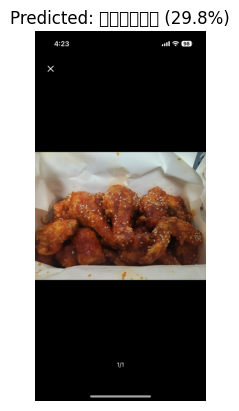

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 후라이드치킨       - 29.82%
🥈 2위: 감바스          - 26.75%
🥉 3위: 양념치킨         - 21.24%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [2/13] sample5.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45392 (\N{HANGUL SYLLABLE NYEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


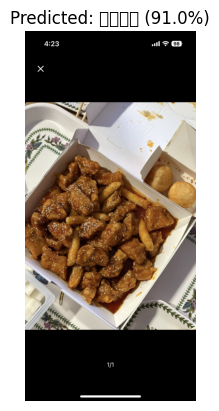

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 91.02%
🥈 2위: 감바스          -  5.96%
🥉 3위: 파스타          -  2.98%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [3/13] sample6.png


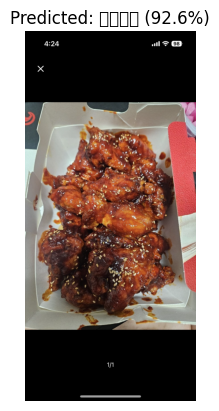

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 92.63%
🥈 2위: 파스타          -  5.77%
🥉 3위: 후라이드치킨       -  1.25%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [4/13] sample7.png


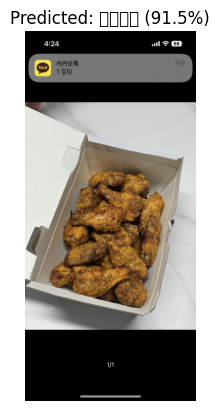

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 91.52%
🥈 2위: 지코바          -  6.16%
🥉 3위: 감바스          -  1.89%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [5/13] sample8.png


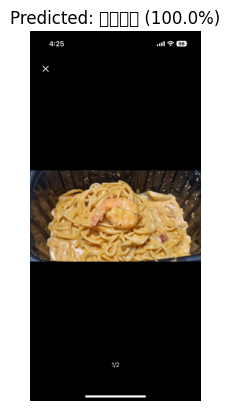

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 100.00%
🥈 2위: 지코바          -  0.00%
🥉 3위: 파스타          -  0.00%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [6/13] sample9.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


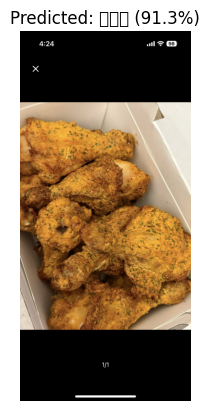

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 지코바          - 91.28%
🥈 2위: 양념치킨         -  7.15%
🥉 3위: 감바스          -  1.44%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [7/13] sample10.png


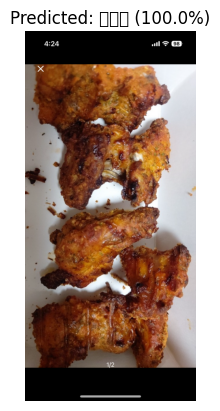

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 지코바          - 99.98%
🥈 2위: 양념치킨         -  0.01%
🥉 3위: 감바스          -  0.01%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [8/13] sample11.png


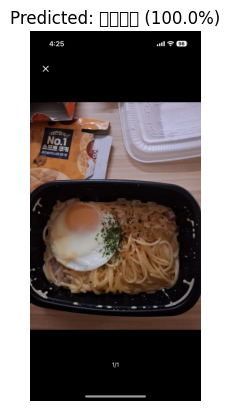

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 100.00%
🥈 2위: 감바스          -  0.00%
🥉 3위: 파스타          -  0.00%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [9/13] sample12.png


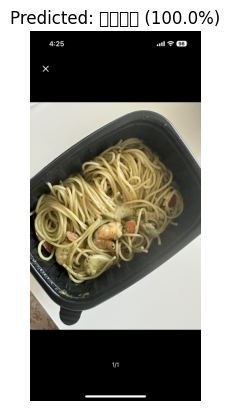

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 100.00%
🥈 2위: 파스타          -  0.00%
🥉 3위: 후라이드치킨       -  0.00%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [10/13] sample13.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


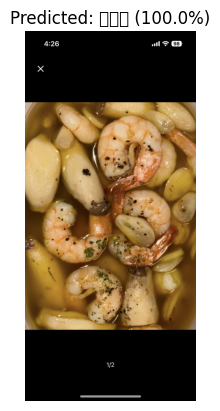

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 100.00%
🥈 2위: 양념치킨         -  0.00%
🥉 3위: 파스타          -  0.00%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [11/13] sample14.png


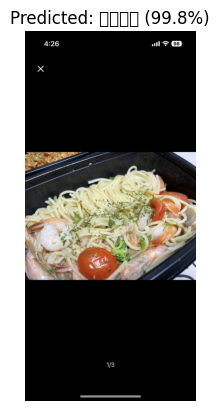

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 99.80%
🥈 2위: 감바스          -  0.14%
🥉 3위: 파스타          -  0.04%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [12/13] sample15.png


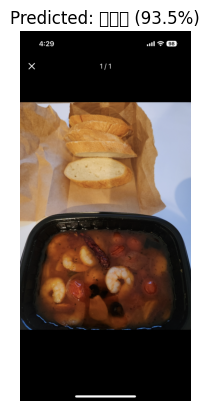

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 93.45%
🥈 2위: 양념치킨         -  5.29%
🥉 3위: 파스타          -  1.14%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [13/13] sample16.png


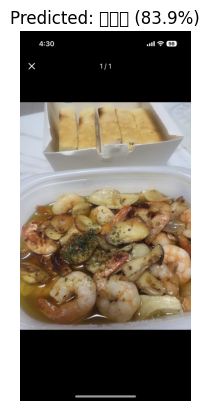

🎯 예측 결과:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 83.94%
🥈 2위: 양념치킨         - 15.70%
🥉 3위: 파스타          -  0.35%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



In [16]:
# 🔄 [예측 Step 2] 샘플 이미지 예측 (전처리 전)
from PIL import Image
import matplotlib.pyplot as plt

def predict_sample(image_path, model, device):
    """
    저장된 EfficientNet 모델을 사용하여 샘플 이미지를 예측하는 함수.
    """
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 224x224 (ResNet 표준)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가 후 device로 이동

    # 모델 예측
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        
        # 상위 3개 클래스와 확률
        top3_probs, top3_indices = torch.topk(probabilities, min(3, len(class_names)))
        predicted = top3_indices[0]

    # 결과 출력
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {class_names[predicted.item()]} ({top3_probs[0]*100:.1f}%)")
    plt.axis('off')
    plt.show()

    print(f"🎯 예측 결과:")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    for i in range(len(top3_indices)):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
        print(f"{emoji} {i+1}위: {class_names[top3_indices[i]]:12s} - {top3_probs[i]*100:5.2f}%")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# 🏆 여러 샘플 이미지 순서대로 예측 실행
base_dir = "/Users/freemanyoo/develop/crawler/multi_crawler"
sample_prefix = "sample"  # 파일명 접두사
sample_ext = ".png"  # 확장자

# sample1.png, sample2.png, ... 순서대로 검증
found_samples = []
for i in range(1, 100):  # sample1 ~ sample99까지 확인
    sample_path = f"{base_dir}/{sample_prefix}{i}{sample_ext}"
    if os.path.exists(sample_path):
        found_samples.append(sample_path)
    elif i > 1 and len(found_samples) > 0:
        # 연속으로 없으면 중단 (예: sample1, sample2 있고 sample3 없으면 중단)
        break

if found_samples:
    print(f"✅ {len(found_samples)}개의 샘플 이미지를 발견했습니다!\n")
    for idx, sample_path in enumerate(found_samples, 1):
        print(f"{'='*60}")
        print(f"📸 [{idx}/{len(found_samples)}] {os.path.basename(sample_path)}")
        print(f"{'='*60}")
        predict_sample(sample_path, loaded_model, device)
        print()
else:
    print(f"⚠️  샘플 이미지를 찾을 수 없습니다!")
    print(f"💡 {base_dir}/sample1.png 형식으로 이미지를 준비해주세요!")
    print(f"   예: sample1.png, sample2.png, sample3.png, ...")


In [ ]:
# 🔄 [예측 Step 3] 배경 제거 + 전처리 후 재예측 (선택사항)
# 🔧 샘플 이미지 배경 제거 + 전처리 후 재예측
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

print("="*60)
print("🔧 샘플 이미지 배경 제거 + 전처리 후 재예측 시작")
print("="*60)
print()

# BiRefNet 모델 로드
print("🤖 BiRefNet 모델 로딩 중...")
print("⚠️  메모리 부족 시 커널이 크래시할 수 있습니다...")
import numpy as np
from transformers import AutoModelForImageSegmentation
import gc

# 메모리 정리
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

try:
    # CNN 모델을 CPU로 이동시켜 GPU 메모리 확보
    loaded_model.to('cpu')
    torch.mps.empty_cache()
    
    with torch.no_grad():
        birefnet = AutoModelForImageSegmentation.from_pretrained(
            'ZhengPeng7/BiRefNet',
            trust_remote_code=True,
            torch_dtype=torch.float16,  # float32 → float16 (메모리 절반)
            low_cpu_mem_usage=True
        )
        birefnet.to(device)
        birefnet.eval()
        torch.mps.empty_cache()
    
    # CNN 모델 다시 GPU로
    loaded_model.to(device)
    
    print("✅ BiRefNet 모델 로딩 완료!")
except Exception as e:
    print(f"❌ BiRefNet 로딩 실패: {e}")
    print("⚠️  배경 제거 없이 진행합니다.")
    birefnet = None
    # CNN 모델 다시 GPU로
    loaded_model.to(device)

print()

def remove_background(image, birefnet_model, device):
    """
    BiRefNet을 사용하여 배경 제거
    """
    if birefnet_model is None:
        return image
    
    from torchvision import transforms as T
    
    # BiRefNet 입력 전처리
    input_size = (1024, 1024)
    transform = T.Compose([
        T.Resize(input_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    # float16으로 변환 (BiRefNet 모델과 타입 맞춤)
    input_tensor = input_tensor.half()
    
    # 배경 제거
    with torch.no_grad():
        preds = birefnet_model(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    pred_pil = T.ToPILImage()(pred)
    mask = pred_pil.resize(image.size)
    
    # RGBA로 변환 (알파 채널에 마스크 적용)
    image_rgba = image.convert("RGBA")
    image_rgba.putalpha(mask)
    
    # 흰색 배경으로 합성
    white_bg = Image.new("RGB", image.size, (255, 255, 255))
    white_bg.paste(image_rgba, (0, 0), image_rgba)
    
    return white_bg


def preprocess_and_predict(image_path, model, birefnet_model, device):
    """
    샘플 이미지를 배경 제거 + 전처리(리사이즈 + 패딩) 후 예측
    """
    # 이미지 불러오기
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    
    # 1. 배경 제거 (학습 데이터와 동일하게)
    image_nobg = remove_background(image, birefnet_model, device)
    
    # 2. 224x224으로 리사이즈 + 패딩 (ResNet 표준)
    target_size = (224, 224)
    
    # 비율 유지하며 리사이즈
    image_nobg.thumbnail(target_size, Image.Resampling.LANCZOS)
    
    # 패딩 추가 (흰색 배경)
    new_image = Image.new("RGB", target_size, (255, 255, 255))
    paste_position = ((target_size[0] - image_nobg.size[0]) // 2,
                      (target_size[1] - image_nobg.size[1]) // 2)
    new_image.paste(image_nobg, paste_position)
    
    # 모델 입력용 전처리
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(new_image).unsqueeze(0).to(device)
    
    # 예측
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        
        # 상위 3개 클래스
        top3_probs, top3_indices = torch.topk(probabilities, min(3, len(class_names)))
        predicted = top3_indices[0]
    
    # 결과 출력
    plt.figure(figsize=(15, 4))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(image_path))
    plt.title(f"1. Original ({original_size[0]}x{original_size[1]})")
    plt.axis('off')
    
    # 배경 제거된 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(image_nobg)
    plt.title(f"2. Background Removed")
    plt.axis('off')
    
    # 최종 전처리된 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(new_image)
    plt.title(f"3. Final (224x224 + padding)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"🎯 예측 결과:")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    for i in range(len(top3_indices)):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
        print(f"{emoji} {i+1}위: {class_names[top3_indices[i]]:12s} - {top3_probs[i]*100:5.2f}%")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    return predicted.item(), top3_probs[0].item()


# 샘플 이미지 전처리 후 예측 실행
base_dir = "/Users/freemanyoo/develop/crawler/multi_crawler"
sample_prefix = "sample"
sample_ext = ".png"

# sample1.png, sample2.png, ... 찾기
found_samples = []
for i in range(1, 100):
    sample_path = f"{base_dir}/{sample_prefix}{i}{sample_ext}"
    if os.path.exists(sample_path):
        found_samples.append(sample_path)
    elif i > 1 and len(found_samples) > 0:
        break

if found_samples:
    print(f"✅ {len(found_samples)}개의 샘플 이미지를 발견했습니다!")
    print(f"🔧 전처리(배경 제거 + 224x224 리사이즈 + 패딩) 적용 중...\n")
    
    results = []
    for idx, sample_path in enumerate(found_samples, 1):
        print(f"{'='*60}")
        print(f"📸 [{idx}/{len(found_samples)}] {os.path.basename(sample_path)}")
        print(f"{'='*60}")
        predicted_class, confidence = preprocess_and_predict(sample_path, loaded_model, birefnet, device)
        results.append((os.path.basename(sample_path), class_names[predicted_class], confidence))
        print()
    
    # 최종 요약
    print("="*60)
    print("📊 전처리 후 예측 결과 요약")
    print("="*60)
    for filename, pred_class, conf in results:
        print(f"{filename:15s} → {pred_class:12s} ({conf*100:5.2f}%)")
    print("="*60)
else:
    print(f"⚠️  샘플 이미지를 찾을 수 없습니다!")
    print(f"💡 {base_dir}/sample1.png 형식으로 이미지를 준비해주세요!")
